# LSTMを用いてUSDJPYの予測を行う。
ディープラーニングを用いてUSDJPYの値動きを予測したい。
時系列データを扱うRNNの一種であるLong Shot Term Memoryを使用する。

LSTM理論
https://qiita.com/KojiOhki/items/89cd7b69a8a6239d67ca

LSTM実装参考
https://qiita.com/sasayabaku/items/b7872a3b8acc7d6261bf

USDJPYヒストリカルデータ
https://www.m2j.co.jp/market/historical.php

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [3]:
df = pd.read_csv('USDJPY.csv')
df.head()

,日付,始値,高値,安値,終値
0,2007/04/02,117.84,118.08,117.46,117.84
1,2007/04/03,117.84,118.98,117.72,118.96
2,2007/04/04,118.92,119.08,118.56,118.72
3,2007/04/05,118.72,118.99,118.44,118.72
4,2007/04/06,118.72,119.39,118.67,119.27


In [4]:
df.columns = ['date','open', 'high', 'low', 'close']
price_cols = ['open', 'high', 'low', 'close']

In [5]:
df_mod  = df.copy()
df_mod[price_cols] = df_mod[price_cols] / df['open'][0]

ヒストリカルデータを全て学習に使ってしまうと、後で予測の検証が出来ないので適当な時点で分割しておく。

In [6]:
num_train = 1000
split_pos = 50
offset = 200

prices = df_mod[price_cols].values[-(num_train + split_pos + offset):]
train = prices[:num_train]
test = prices[num_train:]

データの持ち方としては冗長になるが、ある時点でのTrainデータはあらかじめ決めておいたDurationの分の過去のデータを含むようにしておくと実装の見通しが良い。

In [7]:
def make_dataset(raw_data, duration):
    len_data = raw_data.shape[0]
    dim_data = raw_data.shape[1]
    data_list = []
    target_list =  []
    for i in range(len_data - duration):
        data_list.append(raw_data[i:i+duration])
        target_list.append(raw_data[i+duration])
        
    data = np.array(data_list).reshape([-1,  duration, dim_data])
    target = np.array(target_list).reshape(-1, dim_data)
    
    return data, target

Kerasを使うと複雑なLSTMのモデル実装もたったこれだけ。

In [8]:
def make_model(X, n_hidden=300):
    len_seq = X.shape[1]
    len_out = X.shape[2]

    model = Sequential()
    model.add(LSTM(n_hidden, batch_input_shape=(None, len_seq, len_out), return_sequences=False))
    model.add(Dense(len_out))
    model.add(Activation("linear"))
    optimizer = Adam(lr=0.001)
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    
    return model

def fit_model(model, X, y):
    early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=10)
    model.fit(X, y, batch_size=30, epochs=100, validation_split=0.1, callbacks=[early_stopping])
    return model

予測は、最新のデータから遡ってDuration分を使う。新しい予測が1つ出来たら、引数の一番古いところは捨てて、代わりに予測した値を積む。これを繰り返すことで未来が見えてくるはず。

In [9]:
def predict_future(X_train, model, len_future):
    x = X_train[-1, :, :]
    duration = X_train.shape[1]
    dim = X_train.shape[2]
    pred_list = []
    for _ in range(len_future):
        pred_ = model.predict(x.reshape([1, duration, dim]))
        pred_list.append(pred_)
        x = np.vstack([x[1:], pred_])
        pred_feature = np.array(pred_list).reshape([-1, dim])
    return pred_feature

In [10]:
model_list = []
duration_list = [30, 30, 30, 30, 30]
pred_list = []
future_list = []
for duration in duration_list:
    X_train, y_train = make_dataset(train, duration)
    model = make_model(X_train, n_hidden=300)
    model.summary()
    model = fit_model(model, X_train, y_train)
    future = predict_future(X_train, model, len_future=100)
    
    model_list.append(model)
    pred_list.append(model.predict(X_train))
    future_list.append(future)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 300)               366000    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1204      
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 367,204
Trainable params: 367,204
Non-trainable params: 0
_________________________________________________________________
Train on 873 samples, validate on 97 samples
Epoch 1/100
873/873 [==============================] - 2s 2ms/step - loss: 0.0761 - val_loss: 0.0017
Epoch 2/100
873/873 [==============================] - 1s 1ms/step - loss: 9.4874e-04 - val_loss: 1.6152e-04
Epoch 3/100
873/873 [==============================] - 1s 1ms/step - loss: 2.2674e-04 - val_loss: 1.5967e-04
Epoch 4/100
873/873 [===============

873/873 [==============================] - 1s 2ms/step - loss: 0.0892 - val_loss: 0.0026
Epoch 2/100
873/873 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 3.9110e-04
Epoch 3/100
873/873 [==============================] - 1s 1ms/step - loss: 2.2011e-04 - val_loss: 1.2177e-04
Epoch 4/100
873/873 [==============================] - 1s 1ms/step - loss: 1.7513e-04 - val_loss: 8.5119e-05
Epoch 5/100
873/873 [==============================] - 1s 1ms/step - loss: 1.6902e-04 - val_loss: 9.2900e-05
Epoch 6/100
873/873 [==============================] - 1s 1ms/step - loss: 1.7757e-04 - val_loss: 1.0537e-04
Epoch 7/100
873/873 [==============================] - 1s 1ms/step - loss: 1.5946e-04 - val_loss: 8.0555e-05
Epoch 8/100
873/873 [==============================] - 1s 1ms/step - loss: 1.4756e-04 - val_loss: 4.3429e-05
Epoch 9/100
873/873 [==============================] - 1s 1ms/step - loss: 1.6730e-04 - val_loss: 5.3112e-05
Epoch 10/100
873/873 [=====================

873/873 [==============================] - 2s 2ms/step - loss: 0.1261 - val_loss: 0.0058
Epoch 2/100
873/873 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 8.2262e-04
Epoch 3/100
873/873 [==============================] - 1s 995us/step - loss: 3.5190e-04 - val_loss: 2.7912e-04
Epoch 4/100
873/873 [==============================] - 1s 1ms/step - loss: 2.8030e-04 - val_loss: 1.6408e-04
Epoch 5/100
873/873 [==============================] - 1s 984us/step - loss: 2.6491e-04 - val_loss: 1.1266e-04
Epoch 6/100
873/873 [==============================] - 1s 1ms/step - loss: 2.5456e-04 - val_loss: 7.7643e-05
Epoch 7/100
873/873 [==============================] - 1s 1ms/step - loss: 2.3578e-04 - val_loss: 1.0402e-04
Epoch 8/100
873/873 [==============================] - 1s 1ms/step - loss: 2.4938e-04 - val_loss: 2.1791e-04
Epoch 9/100
873/873 [==============================] - 1s 1ms/step - loss: 2.1062e-04 - val_loss: 7.9480e-05
Epoch 10/100
873/873 [=================

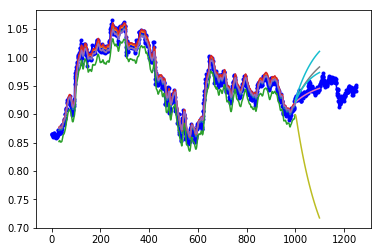

In [12]:
plt.figure()
plt.plot(range(0, len(prices)), prices[:,3], color='b', label='raw_data', marker='.')

cmap = plt.get_cmap("tab10")
for i, pred, duration, model, future  in zip(range(len(pred_list)), pred_list, duration_list, model_list, future_list):
    plt.plot(range(duration, len(pred)+duration), pred[:,3], color=cmap(i), label='predicted_{}'.format(duration))
    plt.plot(range(len(pred)+duration, len(pred)+duration+len(future)), future[:,3], color=cmap(i+6), label='predicted_future_{}'.format(duration))

# plt.ylim(0.90, 0.96)
# plt.xlim(1900, 2100)
#plt.legend()    
plt.show()